# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [4]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output
import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
device

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gregory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'cpu'

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 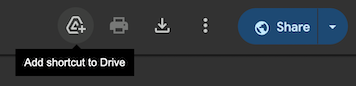

Скачаем данные для обучения и тестирования:

In [3]:
dataset = pd.read_csv('salary_dataset.csv')
dataset.head(20)

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500
5,We are a new fast growing Internet/Telecoms co...,14999
6,AMAZING LEISURE TO BUSINESS TRAVEL CONSULTANT ...,16000
7,Customer Insight Analyst required. c****k top...,27000
8,".Net Software Developer (C and/or VB.NET, SQL ...",30000
9,EXCELLENT OPPORTUNITY Based local to Leigh we...,18000


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [4]:
dataset.iloc[0]["FullDescription"]


'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [5]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

 Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [7]:
counter = Counter()

for text in dataset['FullDescription'].values:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [8]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 269289),
 ('The', 258645),
 ('role', 211475),
 ('work', 207318),
 ('team', 194087),
 ('This', 180149),
 ('within', 175173),
 ('You', 173743),
 ('skills', 162215)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [10]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [11]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [13]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    texts_tensors = [torch.LongTensor(t) for t in texts]
    labels = torch.FloatTensor(target)

    # дополним до макс. длины в батче
    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, labels

Токенизируем текст, а таргет переведем во `float`.

In [14]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [15]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 25000, 25000, 141, 18, 25000, 25000, 3605, 25000, 35, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 25000, 14, 25000, 25000, 4674, 393, 871, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  573, 186, 1517, 658, 0, 24450, 25000, 15730, 13311, 87, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [16]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [17]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.0872, 0.2308, 0.1319, ...


Сформируйте даталоадеры для обучения и валидации.

In [18]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [39]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        output_dim=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """

        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.fc = nn.Linear(rnn_num_units, output_dim)


    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """
        emb = self.emb(x)
        output, _ = self.rnn(emb)
        last_hidden = output[:, -1, :]
        predictions = self.fc(last_hidden)
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [32]:
def MSE(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [33]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        optimizer.zero_grad()
        optimizer.zero_grad()

        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)

        predictions = model(texts).squeeze(1)  # Получаем предсказания модели
        loss = criterion(predictions, labels)  # Вычисляем функцию потерь

        mse = MSE(predictions, labels)

        loss.backward()  # Вычисляем градиенты
        optimizer.step()  # Обновляем параметры модели

        epoch_loss += loss.item()
        epoch_mse += mse.item()
        train_loss_history.append(loss.item())


    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()


    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        for batch_id, batch in enumerate(iterator):
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)

            predictions = model(texts).squeeze(1)  # Получаем предсказания модели
            loss = criterion(predictions, labels)  # Вычисляем функцию потерь
            mse = MSE(predictions, labels)

            epoch_loss += loss.item()
            epoch_mse += mse.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [34]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

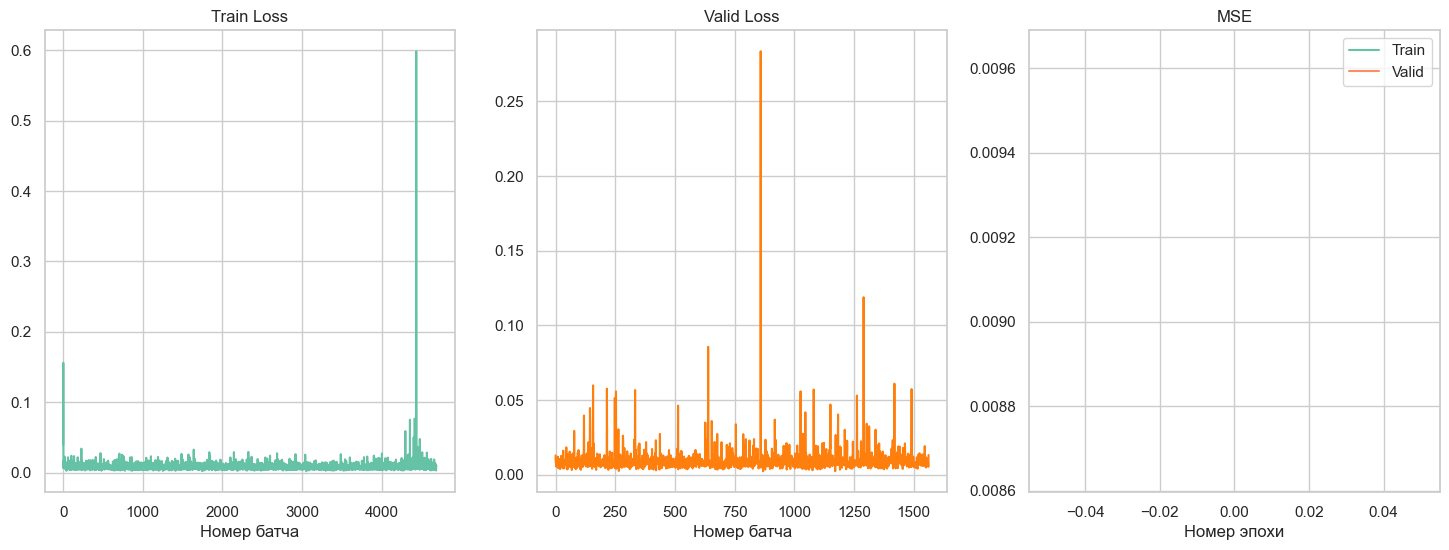

Номер эпохи: 01 | Время обучения эпохи: 26m 57s


KeyboardInterrupt: 

In [35]:
model = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=256,
    output_dim=1,
).to(device)

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

# Посмотрите на получившуюся модель
training_loop(model)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

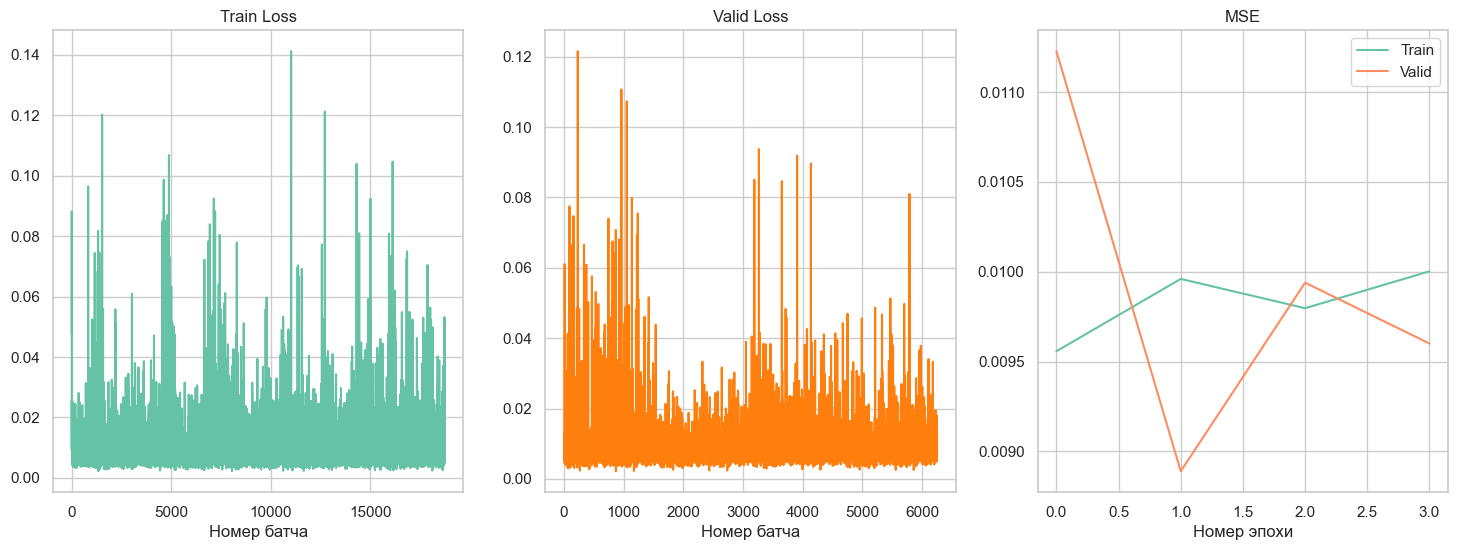

Номер эпохи: 04 | Время обучения эпохи: 11m 53s


KeyboardInterrupt: 

In [ ]:
train_tokens, test_tokens, train_target, test_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
test_target_std = scaler.transform(np.array(test_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
test_data = SalaryPredictionDataset(test_tokens, test_target_std)
len(train_data), len(test_data)
BATCH_SIZE = 32

train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

hyperparams = [
    {"lr": 0.1, "vocab_size": num_tokens, "emb_size": 128, "rnn_units": 64},
    {"lr": 0.2, "vocab_size": num_tokens-5000, "emb_size": 256, "rnn_units": 128},
    {"lr": 0.05, "vocab_size": num_tokens-10000, "emb_size": 192, "rnn_units": 96},
]

for params in hyperparams:
    model = SimpleRNNRegressor(
        num_tokens=params["vocab_size"],
        emb_size=params["emb_size"],
        rnn_num_units=params["rnn_units"],
        output_dim=1
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

    history = []

    training_loop(model)


>В данном примере Valid = Test на графике. MSE в первом случае падает при увеличении количества эпох. Во втором случае как и в третьем скачет.

In [50]:
def print_res(model, test_loader, scaler):
    model.eval()
    true_salaries = []
    predicted_salaries = []
    with torch.no_grad():
        for texts, salaries in test_loader:
            texts = texts.to(device)
            salaries = salaries.to(device)
            predictions = model(texts).squeeze(1)
            predicted_salaries.extend(scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, 1)))
            true_salaries.extend(scaler.inverse_transform(salaries.cpu().numpy().reshape(-1, 1)))
            true_salaries_tensor = torch.tensor(true_salaries)
            predicted_salaries_tensor = torch.tensor(predicted_salaries)


    mse = MSE(true_salaries_tensor, predicted_salaries_tensor)
    print(f"MSE on test set: {mse:.2f}")


    for i in range(5):
        print(f"Example {i + 1}:")
        print("Predicted Salary:", predicted_salaries[i])
        print("True Salary:", true_salaries[i])
        print()

print_res(model, test_loader, scaler)

MSE on test set: 372748704.00
Example 1:
Predicted Salary: [36031.9]
True Salary: [25000.002]

Example 2:
Predicted Salary: [36049.027]
True Salary: [95000.]

Example 3:
Predicted Salary: [36031.28]
True Salary: [28800.]

Example 4:
Predicted Salary: [36032.1]
True Salary: [48000.]

Example 5:
Predicted Salary: [36032.457]
True Salary: [42500.]



**Вывод:**
Во всех случаях зарплата близка к 36030, независимо от ситуации, чему свидетельствует высокий MSE.

---
### Задача 2. Использование большой языковой модели

КОЛАБ УБИЛ
я пытался но у меня всегда было out of memory
использовал модель saiga но там были те же проблемы


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!


In [ ]:
!pip install bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2  > null
import transformers
import bitsandbytes as bnb

assert torch.cuda.is_available(), "для этой части понадобится GPU"

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...





От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [ ]:
model_name = "TheBloke/Llama-2-13B-GPTQ"

# Загружаем Llama токенизатор
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    model_name, device_map=device
)
tokenizer.pad_token_id = tokenizer.eos_token_id

# И саму модель Llama
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

In [ ]:
prompt = <...>
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

**Вывод:**

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*